In [14]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from PIL import Image

# Config
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

DATA_DIR = Path(r"D:\study\cos30082\final_asm\data\zalodata\train\train")
VIDEO_DIR = DATA_DIR / "videos"
LABEL_PATH = DATA_DIR / "label.csv"
FRAME_DIR = DATA_DIR / "frames"
FRAME_DIR.mkdir(exist_ok=True)
MODEL_DIR = Path(r"D:\study\cos30082\final_asm\models")
MODEL_DIR.mkdir(exist_ok=True)




Device: cpu


In [6]:
def extract_frames(video_path, save_dir, video_name):
    cap = cv2.VideoCapture(str(video_path))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    target_frame = total_frames // 2  # middle frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, target_frame)
    ret, frame = cap.read()
    cap.release()

    if ret:
        save_path = save_dir / f"{video_name}.jpg"
        cv2.imwrite(str(save_path), frame)
        return True
    return False

# --- Run extraction ---
df = pd.read_csv(LABEL_PATH)
print("Total videos:", len(df))

for _, row in tqdm(df.iterrows(), total=len(df), desc="Extracting frames"):
    video_file = VIDEO_DIR / row["fname"]
    out_name = Path(row["fname"]).stem
    extract_frames(video_file, FRAME_DIR, out_name)

print("Frame extraction done. Check:", FRAME_DIR)


Total videos: 1168


Extracting frames:   0%|          | 0/1168 [00:00<?, ?it/s]

Extracting frames: 100%|██████████| 1168/1168 [02:11<00:00,  8.91it/s]

Frame extraction done. Check: D:\study\cos30082\final_asm\data\zalodata\train\train\frames


In [7]:
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image

IMG_SIZE = 160
BATCH_SIZE = 32  

frame_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

class ZaloLivenessDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.df = pd.read_csv(csv_path)
        self.img_dir = Path(img_dir)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        fname = Path(row["fname"]).stem + ".jpg"
        img_path = self.img_dir / fname
        img = Image.open(img_path).convert("RGB")
        label = int(row["liveness_score"])   # 1 = real, 0 = spoof
        if self.transform:
            img = self.transform(img)
        return img, label

# make dataset
full_ds = ZaloLivenessDataset(LABEL_PATH, FRAME_DIR, transform=frame_tf)
print("Total extracted samples:", len(full_ds))

# split 80/20
train_size = int(0.8 * len(full_ds))
val_size = len(full_ds) - train_size
train_ds, val_ds = random_split(full_ds, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)

print(f"Train samples: {len(train_ds)} | Val samples: {len(val_ds)}")


Total extracted samples: 1168
Train samples: 934 | Val samples: 234


In [8]:
from torchvision import models
import torch.nn as nn

def build_liveness_model():
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    in_feats = model.fc.in_features
    model.fc = nn.Linear(in_feats, 2)  # 2 classes: 0=spoof, 1=real
    return model

liveness_model = build_liveness_model().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(liveness_model.parameters(), lr=1e-4)
EPOCHS = 5  # you can run more if CPU allows

print("Model ready.")


Model ready.


In [12]:
def evaluate(model, loader):
    model.eval()
    total, correct = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            logits = model(imgs)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())
    acc = correct / total if total > 0 else 0
    return acc, np.array(all_preds), np.array(all_labels)

best_val = 0.0
for epoch in range(1, EPOCHS+1):
    liveness_model.train()
    running_loss = 0.0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}", ncols=90):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        logits = liveness_model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    val_acc, val_preds, val_labels = evaluate(liveness_model, val_loader)
    print(f"Epoch {epoch}: train_loss={train_loss:.4f} | val_acc={val_acc:.4f}")

    # save best
    if val_acc > best_val:
        best_val = val_acc
        torch.save(liveness_model.state_dict(), MODEL_DIR / "liveness_detector_zalo.pt"),
        print("Saved better model (val_acc={:.4f})".format(val_acc))


Epoch 1/5: 100%|██████████████████████████████████████████| 30/30 [00:27<00:00,  1.08it/s]


Epoch 1: train_loss=0.0220 | val_acc=0.9231
Saved better model (val_acc=0.9231)


Epoch 2/5: 100%|██████████████████████████████████████████| 30/30 [00:26<00:00,  1.13it/s]


Epoch 2: train_loss=0.0078 | val_acc=0.9316
Saved better model (val_acc=0.9316)


Epoch 3/5: 100%|██████████████████████████████████████████| 30/30 [00:30<00:00,  1.00s/it]


Epoch 3: train_loss=0.0060 | val_acc=0.9444
Saved better model (val_acc=0.9444)


Epoch 4/5: 100%|██████████████████████████████████████████| 30/30 [00:27<00:00,  1.08it/s]


Epoch 4: train_loss=0.0033 | val_acc=0.9402


Epoch 5/5: 100%|██████████████████████████████████████████| 30/30 [00:26<00:00,  1.13it/s]


Epoch 5: train_loss=0.0016 | val_acc=0.9316


In [15]:
torch.save(liveness_model.state_dict(), MODEL_DIR / "liveness_detector_zalo.pt")

In [16]:
best_model_path = MODEL_DIR / "liveness_detector_zalo.pt"

liveness_model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
liveness_model.eval()

def evaluate_model(model, loader):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            logits = model(imgs)
            probs = torch.softmax(logits, dim=1)[:, 1]
            preds = (probs > 0.5).long()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_prob.extend(probs.cpu().numpy())
    return np.array(y_true), np.array(y_pred), np.array(y_prob)

y_true, y_pred, y_prob = evaluate_model(liveness_model, val_loader)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["spoof(0)", "real(1)"]))

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)

Classification Report:
              precision    recall  f1-score   support

    spoof(0)       0.95      0.92      0.94       126
     real(1)       0.91      0.94      0.93       108

    accuracy                           0.93       234
   macro avg       0.93      0.93      0.93       234
weighted avg       0.93      0.93      0.93       234


Confusion Matrix:
 [[116  10]
 [  6 102]]


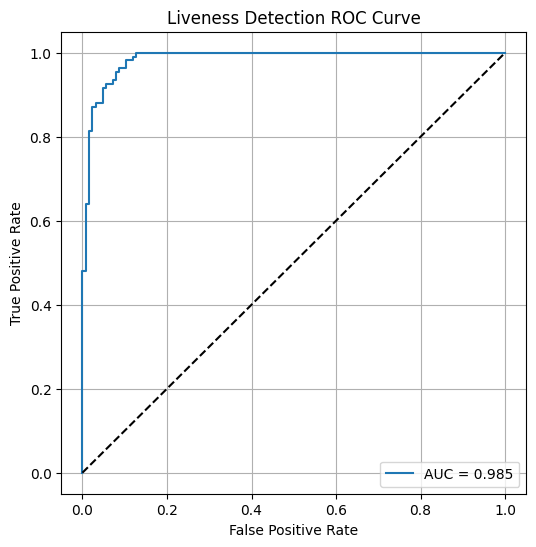

In [17]:
auc = roc_auc_score(y_true, y_prob)
fpr, tpr, _ = roc_curve(y_true, y_prob)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Liveness Detection ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


In [1]:
def predict_liveness_image(img_pil):
    liveness_model.eval()
    x = frame_tf(img_pil).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        logits = liveness_model(x)
        prob_real = torch.softmax(logits, dim=1)[0, 1].item()
    return prob_real

# Example usage
from PIL import Image
sample_img = Image.open(next(FRAME_DIR.glob("*.jpg"))).convert("RGB")
prob = predict_liveness_image(sample_img)
print(f"Liveness probability (real): {prob:.3f}")

if prob < 0.5:
    print("Spoof detected — rejecting input.")
else:
    print("Live face detected — proceed with recognition.")


NameError: name 'FRAME_DIR' is not defined